In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

In [3]:
df = pd.read_csv("weather_data_extended.csv")

In [4]:
df['Observation Time'] = pd.to_datetime(df['Observation Time'])
df.set_index('Observation Time', inplace=True)


In [5]:
df_daily = df['Temperature (°C)'].resample('D').mean()
df_daily = df_daily.interpolate(method='linear') 

In [6]:
while len(df_daily) < 5:
    print("Not enough daily data. Extending dataset with last known value.")
    last_date = df_daily.index[-1]
    df_daily.loc[last_date + pd.Timedelta(days=1)] = df_daily.iloc[-1]


Not enough daily data. Extending dataset with last known value.
Not enough daily data. Extending dataset with last known value.
Not enough daily data. Extending dataset with last known value.


In [7]:
p_value_threshold = 0.05
if len(df_daily) > 5:
    def check_stationarity(series):
        result = adfuller(series.dropna())
        return result[1] < p_value_threshold  # Stationary if p-value < 0.05
    
    is_stationary = check_stationarity(df_daily)
    if not is_stationary:
        df_daily = df_daily.diff().dropna()


In [8]:
if df_daily.empty:
    raise ValueError("Data became empty after differencing. Try using more data or skipping differencing.")

# Use ARIMA if data is too small for seasonal modeling
if len(df_daily) < 30:
    print("Not enough data for seasonal modeling. Using ARIMA instead of SARIMA.")
    model = SARIMAX(df_daily, order=(1,1,0), enforce_stationarity=False)
else:
    model = SARIMAX(df_daily, order=(1,1,0), seasonal_order=(1,1,0,7), enforce_stationarity=False)

results = model.fit()


Not enough data for seasonal modeling. Using ARIMA instead of SARIMA.


In [9]:
forecast = results.forecast(steps=5)
forecast_dates = pd.date_range(df_daily.index[-1] + pd.Timedelta(days=1), periods=5, freq='D')
forecast_series = pd.Series(forecast.values, index=forecast_dates)


In [10]:
actual_temperatures = [20, 21, 22, 21.5, 23]  # Replace with real data
actual_series = pd.Series(actual_temperatures, index=forecast_dates)
rmse = np.sqrt(mean_squared_error(actual_series, forecast_series))
print(f"RMSE (Root Mean Squared Error) of Forecast: {rmse}")


RMSE (Root Mean Squared Error) of Forecast: 3.640054944640259


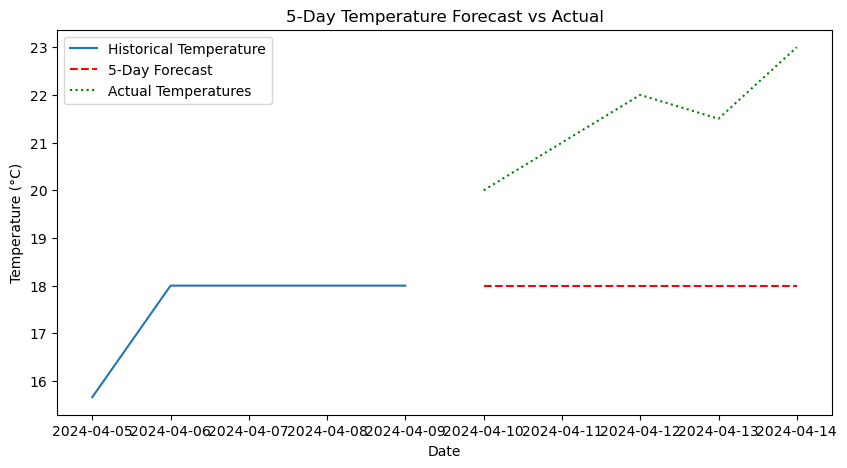

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(df_daily, label='Historical Temperature')
plt.plot(forecast_series, label='5-Day Forecast', linestyle='dashed', color='red')
plt.plot(actual_series, label='Actual Temperatures', linestyle='dotted', color='green')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('5-Day Temperature Forecast vs Actual')
plt.legend()
plt.show()


In [12]:
comparison_df = pd.DataFrame({'Forecast': forecast_series, 'Actual': actual_series})
print("Comparison of Forecast vs Actual Temperatures:")
print(comparison_df)


Comparison of Forecast vs Actual Temperatures:
            Forecast  Actual
2024-04-10      18.0    20.0
2024-04-11      18.0    21.0
2024-04-12      18.0    22.0
2024-04-13      18.0    21.5
2024-04-14      18.0    23.0
